# Riešenie úlohy 3.

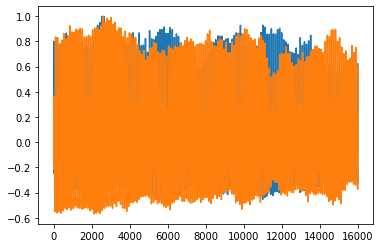

In [3]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import scipy
#tone_maskoff
s_off_full, fs_off = sf.read('../audio/maskoff_tone.wav')
s_off = s_off_full[10000:26000]
t_off = np.arange(s_off.size) / fs_off

#tone_maskon
s_on_full, fs_on = sf.read('../audio/maskon_tone.wav')
s_on = s_on_full[12000:28000]
t_on = np.arange(s_on.size) / fs_on

#ustrednenie
s_off -= np.mean(s_off)
s_on -= np.mean(s_on)


#normalizácia do dynamického rozsahu [-1;+1]
s_off /= np.abs(s_off).max()
s_on /= np.abs(s_on).max()

plt.plot(s_off, label="maskoff")
plt.plot(s_on, label="maskon")

In [4]:
#funkcia ktorá skonstruuje framy zadanemu signalu(podla zadania 320, 160)
def constructFrames(fs):
    frame_length = 16000*0.020 #pocet samplov na frame frame_length = fs * frame_width
    frame_step = (16000*0.020) / 2 #10 ms krok spat
    signal_length = len(fs)
    frames_overlap = frame_length - frame_step
    # vzorec prep počet framov(neodrezzaných)
    num_frames = np.abs(signal_length - frames_overlap) // np.abs(frame_length - frames_overlap)

    #pretypovanie
    frame_length = int(frame_length)
    frame_step = int(frame_step)
    num_frames = int(num_frames)

    idx1 = np.tile(np.arange(0, frame_length), (num_frames, 1))
    idx2 = np.tile(np.arange(0, num_frames * frame_step, frame_step),(frame_length, 1)).T
    indices = idx1 + idx2
    frames = fs[indices.astype(np.int32, copy=False)]
    return frames

#rámce
tone_m_off_frames = constructFrames(s_off)
tone_m_on_frames = constructFrames(s_on)
#uložiť na neskoršie použitie
maskoff_frames = tone_m_off_frames.copy()
maskon_frames = tone_m_on_frames.copy()

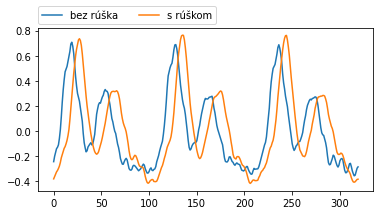

In [5]:
#vykreslenie
import matplotlib.patches as mpatches
plt.figure(figsize=(6,3))
plt.plot(tone_m_off_frames[85], label="bez rúška")
plt.plot(tone_m_on_frames[85], label="s rúškom")
#  uložiť legendu nad graf
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, borderaxespad=0.)

# Riešenie úlohy 4.

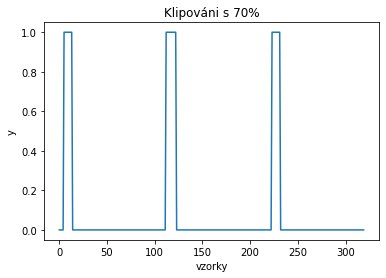

In [6]:
#a) center clipping
def centerClipping(signal):
    for i,frame in enumerate(signal):
        max_70 = max(abs(frame))*0.7 #70% maxima absolútnej hodnoty
        neg_max_70 = 0-max_70
        for j,item in enumerate(frame):
            if(item > max_70):
                frame[j] = 1
            elif(item < neg_max_70):
                frame[j] = -1
            else:
                frame[j] = 0
    return signal

CC_maskoff_frames = centerClipping(tone_m_off_frames)
CC_maskon_frames = centerClipping(tone_m_on_frames)
plt.title("Klipováni s 70%")
plt.ylabel("y")
plt.xlabel("vzorky")
plt.plot(CC_maskoff_frames[0])

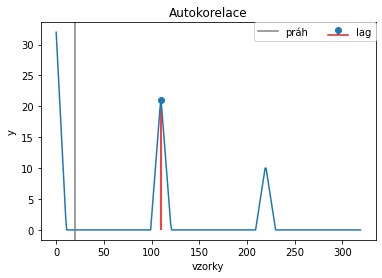

In [7]:
#b) autokorelácia
from numpy.fft import fft, ifft

lags = []
lagvals = []
def autocorrelation(signal):
    base_freq_list = list()
    for i,f in enumerate(signal):
        N = len(f)
        fvi = np.fft.fft(f, n=2*N)
        acf = (np.real( np.fft.ifft( fvi * np.conjugate(fvi) )[:N]))
        acf = np.rint(abs(acf))
        lag_val = max(acf[10:])
        lagvals.append(lag_val)
        lag = np.argmax(acf[20:])+20
        lags.append(lag)
        base_freq= 1 / lag * 16000
        base_freq_list.append(base_freq)
        signal[i] = acf
    return base_freq_list

maskoff_base_freq = autocorrelation(CC_maskoff_frames)
maskon_base_freq = autocorrelation(CC_maskon_frames)

plt.title("Autokorelace")
plt.ylabel("y")
plt.xlabel("vzorky")
plt.plot(CC_maskoff_frames[10])
plt.axvline(20,color='gray', label="práh")
plt.stem([lags[10]], [lagvals[10]], 'r-', label="lag")
plt.legend(loc='upper right',ncol=2, borderaxespad=0.)

148.14814814814815
148.14814814814815
1.4810046002750654
1.0449961364824871


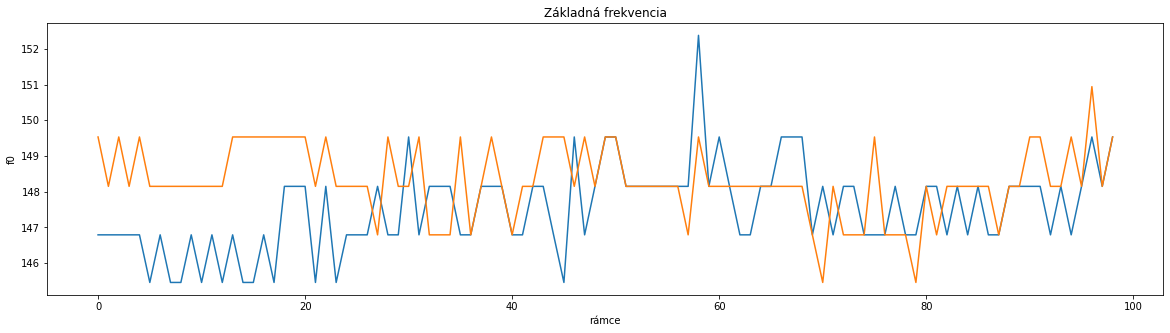

In [8]:
#c) základná frekvencia
plt.figure(figsize=(20,5))
plt.title("Základná frekvencia")
plt.ylabel("f0")
plt.xlabel("rámce")
plt.plot(maskoff_base_freq)
plt.plot(maskon_base_freq)

maskoff_median = np.median(maskoff_base_freq)
maskon_median = np.median(maskon_base_freq)

maskoff_variance = np.var(maskoff_base_freq)
maskon_variance = np.var(maskon_base_freq)

print(maskoff_median)
print(maskon_median)
print(maskoff_variance)
print(maskon_variance)

# Riešenie úlohy 5


In [9]:
#a) dft numpy
maskoff_DFT = np.fft.fft(maskoff_frames, 1024)
maskon_DFT = np.fft.fft(maskon_frames, 1024)
#b) vlastná DFT
def dft(signal):
    result = []
    for frame in signal:
        t = []
        N = len(frame)
        for i in range(N):
            a = 0
            for n in range(N):
                a += frame[n]*np.exp(-2j*np.pi*i*n*(1/N))
            t.append(a)
        result.append(t)
    return result
#vlastná implementácia je značne pomalšia ako np.fft.fft, dalej používam knihovňu
#maskoff_own_DFT = dft(tone_m_off_frames)
#plt.plot(maskoff_own_DFT[10])

spektogramy

<function matplotlib.pyplot.show(close=None, block=None)>

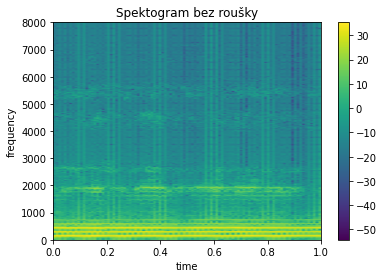

In [10]:
#-----spectogram
#bez rúška
maskoff_DFT_log = 10 * np.log10(np.abs(maskoff_DFT.T)**2)
maskoff_extent = [0 , 1, 0 , 8000]
maskoff_spectogram = np.array(maskoff_DFT_log)[0:512]

plt.title("Spektogram bez roušky")
plt.ylabel("frequency")
plt.xlabel("time")
plt.imshow(maskoff_spectogram[::-1], extent=maskoff_extent, aspect="auto")
cbar = plt.colorbar()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

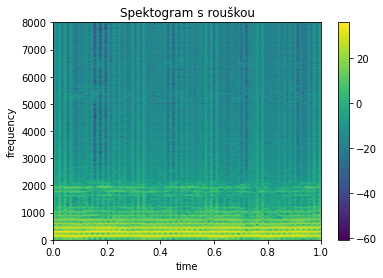

In [11]:
#s rúškom
maskon_DFT_log = 10*np.log10(np.abs(maskon_DFT.T)**2)
maskon_extent = [0 , 1, 0 , 8000]
maskon_spectogram = np.array(maskon_DFT_log)[0:512]
plt.title("Spektogram s rouškou")
plt.ylabel("frequency")
plt.xlabel("time")
plt.imshow(maskon_spectogram[::-1], extent=maskon_extent, aspect="auto")
cbar = plt.colorbar()
plt.show

# Riešenie úlohy 6

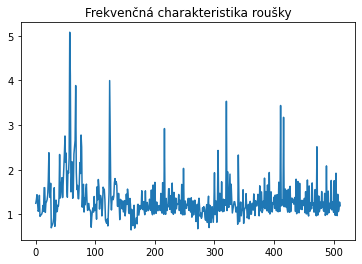

In [12]:
#H(e^jw) = dft(maskon) / dft(maskoff)
H = np.array(abs(maskon_DFT) / abs(maskoff_DFT))
H_avg = H.mean(axis=0)
plt.title("Frekvenčná charakteristika roušky")
plt.plot(H_avg[0:512])

# Riešenie úlohy 7

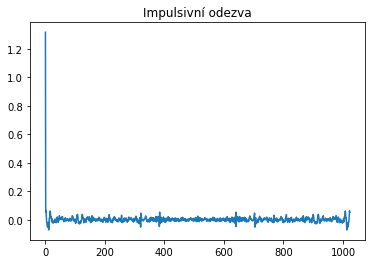

In [13]:
#implementácia IDFT
def idft(signal):
    result = []
    for frame in signal:
        x = []
        N = len(frame)
        for n in range(N):
            a = 0
            for k in range(N):
                a += frame[k]*np.exp(2j*np.pi*k*n*(1/N))
            a /= N
            x.append(a)
        result.append(x)
    return result
#opäť je vlastná implementácia inverznej fourienovej transformácie veľmi pomalá oproti np.fft.IFFT
impulse_response = np.fft.ifft(H_avg)
plt.title("Impulsivní odezva")
plt.plot(impulse_response.real)



# Riešenie úlohy 8

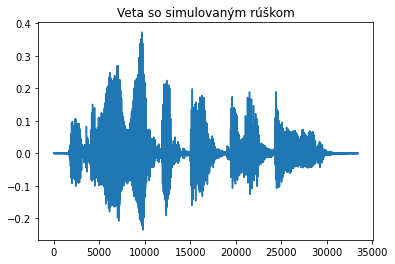

In [14]:
from scipy import signal
import wave
#sim = lfilter(s_off, a, imp)
s_maskoff_sentence, fs_maskoff_sentence = sf.read('../audio/maskoff_sentence.wav')
s_maskon_sentence, fs_maskon_sentence = sf.read('../audio/maskon_sentence.wav')

simulation_maskon_sentence = scipy.signal.lfilter([1.0],impulse_response.real, s_maskoff_sentence)
simulation_maskon_tone = scipy.signal.lfilter([1.0],impulse_response.real, s_off_full)

plt.title("Veta so simulovaným rúškom")
#plt.plot(s_maskoff_sentence, label="Bez rúška")
plt.plot(simulation_maskon_sentence, label="So Simulovaným rúškom")
#plt.plot(s_maskon_sentence,label="S rúškom")
#plt.legend(bbox_to_anchor=(0., 1.2, 1., .150), loc='upper right',ncol=2, borderaxespad=0.)

#create wav file
def createWAV(name, signal):
    audio = wave.open(name, "wb")
    audio.setnchannels(1)
    audio.setsampwidth(2)
    audio.setframerate(16000)
    output = (signal * 32767).astype(np.int16)
    audio.writeframesraw(output)
    audio.close()
    return

createWAV("../audio/sim_maskon_sentence.wav", simulation_maskon_sentence)
#import IPython
#print("Simulované rúško: ")
#IPython.display.display(IPython.display.Audio(simulation_maskon_sentence, rate=16000))
#print("Reálne rúško: ")
#IPython.display.display(IPython.display.Audio(s_maskon_sentence, rate=16000))
#print("Bez rúška: ")
#IPython.display.display(IPython.display.Audio(s_maskoff_sentence, rate=16000))

# Doplňujúce úlohy

# Riešenie úlohy 10

## Overlap-add

In [15]:
def overlap_add(flt, sig):
    L_I = flt.shape[0]
    #mocnina 2 väčšia ako. 2*L_I(zo stackoverflow)
    L_F = 2<<(L_I-1).bit_length()
    L_S = L_F - L_I + 1
    L_sig = sig.shape[0]
    offsets = range(0, L_sig, L_S)

    # komplexne a reálne čísla
    if np.iscomplexobj(flt) or np.iscomplexobj(sig):
        fft_func = np.fft.fft
        ifft_func = np.fft.ifft
        res = np.zeros(L_sig+L_F, dtype=np.complex128)
    else:
        fft_func = np.fft.rfft
        ifft_func = np.fft.irfft
        res = np.zeros(L_sig+L_F)

    FDir = fft_func(flt, n=L_F)

    # overlap and add
    for n in offsets:
        res[n:n+L_F] += ifft_func(fft_func(sig[n:n+L_S], n=L_F)*FDir)
    return res[:L_sig]

sim_maskon_sentence_overlap_add = overlap_add(impulse_response.real,s_maskoff_sentence)
sim_maskon_tone_overlap_add = overlap_add(impulse_response.real, s_off_full)

createWAV("../audio/sim_maskon_sentence_overlap_add.wav", sim_maskon_sentence_overlap_add)
createWAV("../audio/sim_maskon_tone_overlap_add.wav", sim_maskon_tone_overlap_add)

# Riešenie úlohy 11

## Blackman Window

In [16]:
from scipy import signal
#maskoff_frames, maskon_frames
window = signal.blackman(320)
maskoff_frames_window = maskoff_frames * window

### a) Väčšina odkazov na Blackmanovo okno pochádza z literatúry o spracovaní signálu, kde sa používa ako jedna z mnohých okienkových funkcií na vyhladenie hodnôt. Je tiež známa ako "apodization" (čo znamená „odstránenie chodidla“, t. j. Vyhladenie nesúvislostí na začiatku a na konci vzorkovaného signálu) alebo zužujúca sa funkcia.

### b) Blackmann function graf v časovej a spektralnej oblasti

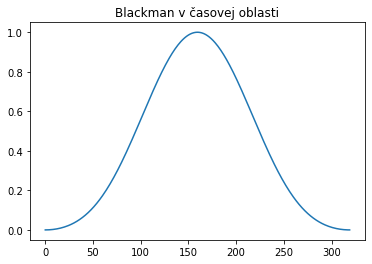

In [17]:
plt.title("Blackman v časovej oblasti")
plt.plot(window)

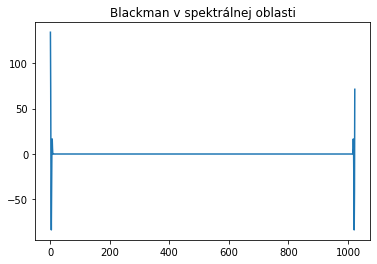

In [18]:
window_dft = np.fft.fft(window, 1024)
#print(window)
#print(window_dft)
plt.title("Blackman v spektrálnej oblasti")
plt.plot(window_dft.real)

### c) Porovnanie rámca

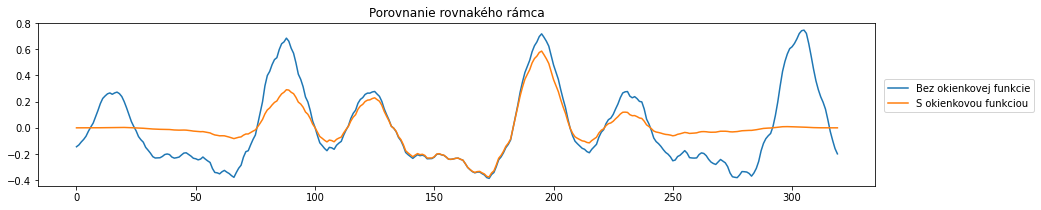

In [19]:
maskoff_frames_window = maskoff_frames * window
maskon_frames_window = maskon_frames * window
plt.figure(figsize=(15,3))
plt.title("Porovnanie rovnakého rámca")
plt.plot(maskoff_frames[50], label="Bez okienkovej funkcie")
plt.plot(maskoff_frames_window[50], label="S okienkovou funkciou")
plt.legend(bbox_to_anchor=(1.01, 0.45, 1., .102), loc='lower left', borderaxespad=0.)

### vytvorenie nahrávky

In [20]:
s_maskoff_sentence, fs_maskoff_sentence = sf.read('../audio/maskoff_sentence.wav')
s_maskoff_tone, fs_maskoff_tone = sf.read('../audio/maskoff_tone.wav')

maskoff_frames_window_DFT = np.fft.fft(maskoff_frames_window, 1024)
maskon_frames_window_DFT = np.fft.fft(maskon_frames_window, 1024)
H_window = np.array(abs(maskon_frames_window_DFT) / abs(maskoff_frames_window_DFT))
H_window_avg = H_window.mean(axis=0)

impulse_response_window = np.fft.ifft(H_window_avg)

sim_maskon_sentence_window = scipy.signal.lfilter([1.0],impulse_response_window.real, s_maskoff_sentence)
sim_maskon_tone_window = scipy.signal.lfilter([1.0],impulse_response_window.real, s_maskoff_tone)

createWAV("../audio/sim_maskon_sentence_window.wav", sim_maskon_sentence_window)
createWAV("../audio/sim_maskon_tone_window.wav", sim_maskon_tone_window)

# Riešenie úlohy 13

## Výpočet frekvenčnej charakteristiky iba s rámcov s rovnakým f0

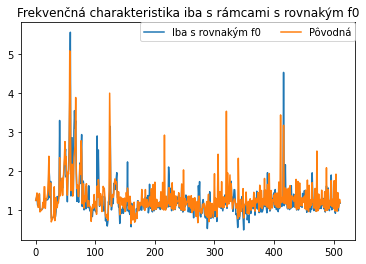

In [21]:
from scipy.signal import freqz
match_indices = [] #frames with same H

#vybrať indexy s rovnakými f0
for i, (a, b) in enumerate(zip(maskon_base_freq, maskoff_base_freq)):
    if(a == b):
        match_indices.append(i)
        #print(i, a, b)

#vybrať framy s rovnakými f0
maskon_match_frames = list()
maskoff_match_frames = list()
for index in match_indices:
    maskon_match_frames.append(maskon_frames[index])
    maskoff_match_frames.append(maskoff_frames[index])

maskoff_match_DFT = np.fft.fft(maskoff_match_frames, 1024)
maskon_match_DFT = np.fft.fft(maskon_match_frames, 1024)

H_match = np.array(abs(maskon_match_DFT) / abs(maskoff_match_DFT))
H_match_avg = H_match.mean(axis=0)

plt.title("Frekvenčná charakteristika iba s rámcami s rovnakým f0")
plt.plot(H_match_avg[0:512], label="Iba s rovnakým f0")
plt.plot(H_avg[0:512], label="Pôvodná")
plt.legend(loc='upper right',ncol=2, borderaxespad=0.)